<a href="https://colab.research.google.com/github/datascience-uniandes/linear-regression-tutorial/blob/master/crabs/linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

MINE-4101: Applied Data Science  
Univerisdad de los Andes  

**Business context:** CrabsAlpes es una empresa líder en la industria pesquera que se especializa en la captura y distribución de cangrejos en la región de los Alpes. A medida que la demanda de cangrejos ha aumentado, también ha crecido la necesidad de entender con precisión las características y calidad de sus capturas. Parte de la calidad se relaciona con la edad del cangrejo, ya que puede influir en el sabor y textura de la carne. Sin embargo, determinar la edad exacta de un cangrejo solo a través de su apariencia es un reto. Por ello, CrabAlpes quiere desarrollar un modelo de regresión lineal que pueda estimar la edad de un cangrejo basándose en características físicas medibles como la longitud, el diámetro, el peso, entre otras. Con este modelo, la empresa espera mejorar la clasificación y venta de sus productos, garantizando a sus clientes un estándar de calidad y frescura uniforme.

**Dataset:** Crab Age Prediction, source: [Kaggle](https://www.kaggle.com/datasets/sidhus/crab-age-prediction).

**Data dictionary:**  
- Sex (char): Sexo. Masculino, femenino o indeterminado.  
- Length (numeric): Longitud.  
- Diameter (numeric): Diámetro.  
- Height (numeric): Altura.  
- Weight (numeric): Peso.  
- Shucked Weight (numeric): Peso descascarado.  
- Viscera Weight (numeric): Peso de las vísceras.  
- Shell Weight (numeric): Peso del caparazón.  
- Age (numeric): Edad. 

Last update: September, 2023

In [ ]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

## 1. Carga de los datos

In [ ]:
crabs_df = pd.read_csv("./data/CrabAgePrediction.csv")

In [ ]:
crabs_df.shape

In [ ]:
crabs_df.dtypes

In [ ]:
crabs_df.sample(5)

## 2. Entendimiento y limpieza de los datos

Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Con ayuda de los expertos, se seleccionan las variables numéricas que se consideran más importantes para la estimación de la variable objetivo (target) `Age`. Para este caso se decide prescindir de la variable `Weight` dado que se considera que se puede realizar una estimación más precisa teniendo en cuenta los pesos individuales de sus partes.

Adicionalmente, tanto las variables de entrada como la variable objetivo no deben contener valores vacíos. Se decide eliminar los registros que tengan valores vacíos en algunas de estas, dado que el experto recomienda no realizar ninguna imputación.

<span style="color: red;">Recuerde que la eliminación de registros debe ser considerada la última opción durante el proceso de limpieza de datos.</span>

In [ ]:
features = ["Length", "Diameter", "Height", "Shucked Weight", "Viscera Weight", "Shell Weight"]

In [ ]:
crabs_df[["Age"]+features].isnull().sum() / crabs_df.shape[0]

In [ ]:
crabs_df = crabs_df.dropna(subset=["Age"]+features)

In [ ]:
crabs_df.shape

In [ ]:
crabs_df[["Age"]+features].isnull().sum() / crabs_df.shape[0]

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

In [ ]:
sns.pairplot(crabs_df.sample(frac=0.2), height=4, y_vars="Age", x_vars=features, kind="scatter")

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(crabs_df[features].corr(), cmap="Blues", vmin=0, vmax=1)

Un buen punto de corte (empírico) para decidir si descartar una variable debido a su alta correlación con otra es ~$|0.8|$. Este análisis se retomará más adelante durante la comprobación de supuestos.

## 3. Prepración de datos

Por lo general, en el Machine Learning supervisado también suele ser común verificar si existen registros duplicados, particularmente para el conjunto de variables de entrada y variable objetivo. Mantener registros duplicados, aún sin considerarse un problema de calidad de los datos, ocasionará que durante el proceso de aprendizaje el algoritmo otorgue de forma errónea un peso mayor a estos registros duplicados.

In [ ]:
total_rows = crabs_df.shape[0]
total_rows

In [ ]:
crabs_df.loc[crabs_df.duplicated(subset=features, keep=False)].head(3)

In [ ]:
duplicated_rows = crabs_df.loc[crabs_df.duplicated(subset=features, keep=False)].shape[0]
duplicated_rows

In [ ]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

In [ ]:
crabs_df.loc[crabs_df.duplicated(subset=features+["Age"], keep=False)].tail(4)

In [ ]:
duplicated_rows = crabs_df.loc[crabs_df.duplicated(subset=features+["Age"], keep=False)].shape[0]
duplicated_rows

In [ ]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Aquí hay dos escenarios a analizar:
1. Existe un ~0.49% de registros con variables de entrada duplicadas, incluso con variable objetivo diferente. Una cantidad no muy preocupante pero que, en términos generales, requeriría de un proceso complementario de limpieza de datos para evitar confundir al modelo al momento de aprender la función de estimación.
2. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el 0.2% registros duplicados adicionales. Para un porcentaje mayor esto representaría potencialmente otro problema obligando al algoritmo de optimización a enfocarse más en aquellos registros duplicados en lugar de ponderar todos los registros por igual.

In [ ]:
crabs_df.drop_duplicates(subset=features, inplace=True)
crabs_df.drop_duplicates(subset=features+["Age"], inplace=True)

In [ ]:
crabs_df.shape

## 4. Particionamiento del conjunto de datos en entrenamiento y prueba

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos previamente desconocidos.

Metodológicamente, una práctica común para validar esto es separando el conjunto de datos etiquetado en dos partes: entrenamiento y prueba. La proporción reservada para probar el modelo es definida por el analista, pero un valor común es 30%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(crabs_df[features], crabs_df["Age"], test_size=0.3, random_state=1)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

## 5. Entrenamiento de un primer modelo de regresión lineal

Se deice que la regresión es lineal dado que se asume una relación lineal entre las variables de entrada (features) y la variable objetivo (target).

En Scikit-Learn existen varias formas de implementar el algoritmo de regresión lieal, pero dado que el objetivo de esta practica esta enfocado en el análisis del modelo resultante y no tanto del algoritmo o del proceso de entrenamiento, se utilizará la implementación más sencilla dada por la clase LinearRegression.

In [ ]:
regression = LinearRegression()

In [ ]:
regression.fit(X_train, y_train)

### 4.1. Interpretación de los coeficientes y del intercepto

Los coeficientes de la regresión brindan una intuición del impacto o la fuerza de una variable de entrada en la predicción/estimación de la variable objetivo.

In [ ]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

In [ ]:
regression.intercept_

In [ ]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Recuerde que el modelo de regresión lineal para este caso particular está dado de la forma

$$ y = {\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3} + \beta_{4}x_{4} + \beta_{5}x_{5}} $$

siendo $\beta_{0}$ el intercepto (bias) y $\beta_{1}$, $\beta_{2}$, $\beta_{3}$, $\beta_{4}$ y $\beta_{5}$ los coeficientes o parámetros correspondientes a las variables de entrada en el mismo orden.

Tenga en cuenta que:
1) El signo del coeficiente representa la dirección de la relación entre la variable de entrada correspondiente y la variable objetivo. Signos positivos implican que si el valor de la variable de entada aumenta, el valor de la variable objetivo también aumentará, mientras que signos negativos indican que si el valor de la variable de entrada aumenta, el valor de la variable objetivo disminuirá.
2) El valor del coeficiente cuantifica la magnitud de la relación, implicando que un aumento o disminución (dependiendo del signo del coeficiente) en una unidad de la variable de entrada representará un cambio equivalente al valor del coeficiente en la variable objetivo, asumiendo que los valores de las demás variables de entrada permanezcan constantes.

**Ejemplo:**

Haciendo énfasis en `valence`, se sabe que cada cambio unitario en esta variable tendrá un impacto porcentual equivalente a ~11.4% en la variable objetivo, asumiendo que los valores de las demás variables permanecen constantes.

In [ ]:
# Dado que `Diameter` se encuentra en el rango de 0 a 1, se simula un cambio de 0.1 múltiples veces para un mismo registro
# Siendo el incremento de apenas 1/10 de unidad, se espera un cambio en la estimación de la variable objetivo de ~0.57%
df = pd.concat([crabs_df[features].iloc[0:1]] * 5).reset_index()
df["Diameter"] = df["Diameter"] + (df.index / 10)
df["prediction"] = regression.predict(df[features])
df["% change"] = df["prediction"].diff()
df

Aún cuando el cambio en la variable objetivo es el esperado, note que las variables de entrada no se encuentran en la misma escala, rangos o grados de magnitud. Debido a esto, las magnitudes o valores de los coeficientes no son directamente comparables entre sí, es decir, no es posible decir por ejemplo que `Diameter` tiene un impacto mayor que `Shell Weight` en la estimación de la edad de un cangrejo. Aunque si se puede decir que `Length` tiene un impacto negativo en la estimación.

Por otro lado, el intercepto puede ser útil para determinar un valor de base en la estimación, en este caso una edad mínima bajo el supuesto de que pudiera existir un cangrejo con todas sus variables de entrada iguales a cero.

### 4.2. Validación (evaluación) del modelo

La forma más básica para saber que tan bien se comporta el modelo es midiendo que tanto se alejan las estimaciones o predicciones del mismo respecto a la variable objetivo real. Esta medición se puede hacer tanto para el conjunto de datos de entrenamiento como para el de prueba.

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [ ]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

In [ ]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

**Análisis del error**

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Age}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [ ]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

Aún cuando `Age` se mueve en el rango de 3 a 27, la mayoría de sus posibles valores se encuentran entre 5 y 15. Tener esto claro es importante para determinar que tan grande o que tan bajo es el error promedio respecto a la variable objetivo.

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Age}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [ ]:
abs(y_test-regression.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

Se podría decir que los resultados de este primer modelo son aceptables dado que:
1) Las métricas de error para el dataset de entrenamiento y prueba son muy similares. No se evidencian problemas de sobreajuste (overfitting).
2) Para el conjunto de prueba los valores de la variable objetivo están centrados en $9.8 \pm 3.1$, mientras que el 75% de los errores de estimación del modelo se encuentran por debajo de 2.1, muy por debajo de una desviación estándar.

Un análisis del error más profundo implicaría, por ejemplo, identificar si el problema mayor se encuentra en la subestimación o la sobreestimación de la edad, así como ganar mayor intuición de cuales son los casos particulares en los que el modelo se equivoca más.

## 6. Entrenamiento de un segundo modelo aplicando normalización

Scikit-Learn permite integrar el proceso de normalización de features dentro de los procesos de entrenamiento y predicción de los modelos mediante el uso de Pipelines. Un Pipeline permite ejecutar de forma secuencial un conjunto de transformaciones de datos, selección de variables, entre otros, seguido del paso de entrenamiento o predicción.

La documentación oficial de Pipelines se puede encontrar aquí: https://scikit-learn.org/stable/modules/compose.html.

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

In [ ]:
pipeline["model"].intercept_

In [ ]:
y_train.mean(), y_test.mean()

Aunque tras la transformación de las variables de entrada se pierde un poco de interpretabilidad de los datos, los coeficientes de la regresión ahora son directamente comparables, pudiendo decir que la variable de entrada que mayor tiene impacto en la variable objetivo es `Shell Weight`, muy por encima de `Diameter` que es la siguiente en magnitud. No se debe olvidar los coeficientes negativos, particularmente el correspondiente a la variable `Shucked Weight`, el cuál tiene una magnitud alta muy similar a `Shell Weight` en términos de valor absoluto.

La forma de entender el intercepto también cambia un poco. Al haber normalizado las variables de entrada, particularmente al haber centrado cada variable en cero removiendo su valor promedio, el valor del intercepto indica cual sería el valor de edad para un cangrejo promedio. Esto tiene sentido dado que corresponde con el valor promedio real (aproximado) de `Age` tanto para el conjunto de entrenamiento como para el de prueba.

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

<span style="color: red;">Recuerde que la normalización de datos no siempre implica mejores métricas de error pero si garantiza un mejor proceso de entrenamiento y, dependiendo de la técnica de normalización utilizada, menor sensibilidad a valores atípicos.</span>

## 7. Validación de supuestos de la regresión

La construcción de un buen modelo de Machine Learning va más allá de solamente minimizar las métricas de error. El modelo de regresión lineal, desde una perspectiva clásica, debería además cumplir con los siguientes supuestos:

*Se volverán a revisar algunos aspectos que se habían descubierto en la etapa de entendimiento de los datos.*

### 7.1. Colinealidad

Es necesario que las variables utilizadas no tengan (o tengan muy baja) colinealidad (correlación).

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [ ]:
X_train.corr()

En este caso particular, para evitar eliminar un importante número de variables, se opta por eliminar aquellas cuyo valor de correlación es superior al 90%.

In [ ]:
features2 = ["Length", "Height", "Shucked Weight", "Shell Weight"]

In [ ]:
X_train[features2].corr()

In [ ]:
pipeline.fit(X_train[features2], y_train)

In [ ]:
pd.DataFrame({"columns": features2, "coef": pipeline["model"].coef_})

In [ ]:
pipeline["model"].intercept_

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

Hay algunos argumentos para decir que este nuevo modelo podría considerarse mejor que los anteriores:
1. Con el uso de menos variables de entrada (menor complejidad del modelo) se logra obtener unas métricas de error muy similares.
2. Se evidencia un mejor balance entre coeficientes de `Length` y `Height`, sin embargo, aún se observa coeficientes altos para `Shucked Weight` y `Shell Weight`. Idealmente, los coeficientes deberían estar lo más balanceados posible para evitar que el modelo sesgue sus estimaciones con base en solo unas pocas variables.

### 7.2. Linealidad

Es necesario que la relación entre cada variable de entrada y la varable objetivo sea lineal.

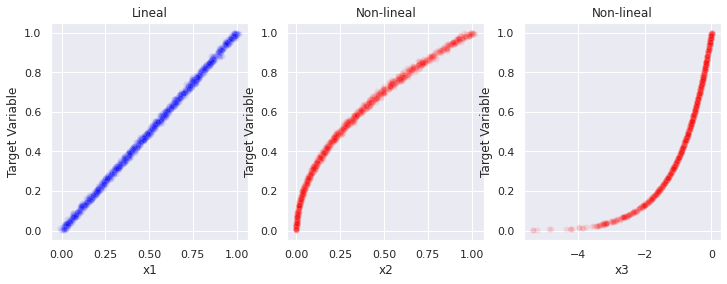

In [ ]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="Age", x_vars=features2, kind="scatter")

¿Es posible que `Shucked Weight` y `Shell Weight` tengan una relación no lineal?

La forma más común de comprobarlo es agregar una transformación polinomial (PolynomialFeatures) de algún grado integrada al Pipeline. Tenga en cuenta que la transformación se aplicará a todas las variables de entrada y será labor del algoritmo de regresión determinar cuáles son las más relevantes para la estimación.

La documentación oficial de PolynomialFeatures se puede encontrar aquí: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html.

In [ ]:
pipeline = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train[features2], y_train)

In [ ]:
pd.DataFrame({"columns": pipeline["poly"].get_feature_names_out(), "coef": pipeline["model"].coef_})

<span style="color: red;">Note que PolynomialFeatures no solo transforma las variables de entrada aplicando el grado deseado, también conserva las variables originales e incluye interacciones (multiplicación) entre estas. Esto hace que la interpretación de los coeficientes se vuelva más dificil.</span>

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

Nuevamente, aplicar este tipo de ajustes no asegura obtener un modelo con un menor error. Algunas razones por las cuáles el RMSE en el dataset de prueba aumento en lugar de disminuir pueden ser:

1. La existencia de algunos valores atípicos solamente en el dataset de test los cuales se agravaron al aplicar la transformación polinomial.
2. Tal como se videncia en las gráficas anteriores, si bien la relación con la variable objetivo puede no ser lineal, lo más probable es que tampoco sea polinómica sino más bien logaritmica.

### 7.3. Normalidad de los errores

Los errores deben tener una distribución normal.

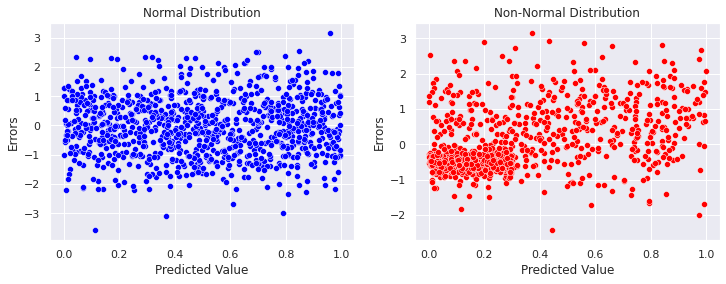

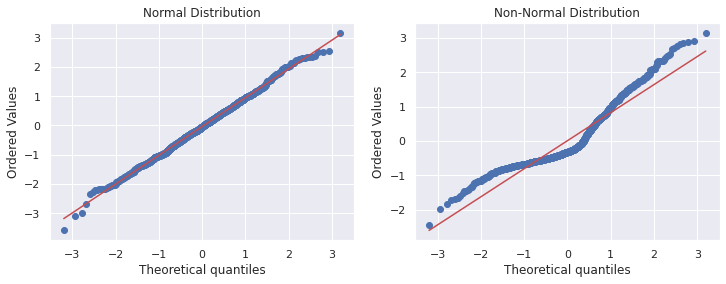

In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [ ]:
pipeline.fit(X_train[features2], y_train)

In [ ]:
errors = (pipeline.predict(X_train[features2])-y_train).values

Valores negativos indican subestimación mientras que valores positivos indican sobreestimación.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[features2]), y=errors, alpha=0.1, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Una estrategia para mejorar este escenario es eliminar los registros cuyo valor de variable objetivo pueda considerarse un valor atípico.

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_train, showmeans=True, orient="h")
plt.title("Valor real de $\t{Age}$ en el conjunto de entrenamiento")
plt.grid()
plt.show()

Para determinar los valores atípicos a remover se puede aplicar la regla $$outlier > Q3 + 1.5*IQR$$

In [ ]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3-q1
threshold = q3+1.5*iqr
threshold

In [ ]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [ ]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [ ]:
pipeline.fit(X_train[features2], y_train)

In [ ]:
pd.DataFrame({"columns": features2, "coef": pipeline["model"].coef_})

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

In [ ]:
errors = (pipeline.predict(X_train[features2])-y_train).values

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[features2]), y=errors, alpha=0.1, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Se siguen teniendo mejoras en las métricas de error y se resuelve el problema de no normalidad de los errores.

<span style="color: red;">Desde el punto de vista de la estadística clásica esto está bien, pero también se debe preguntar: Si las canciones removidas son atípicas pero reales, es decir no obedecen a un problema en los datos, ¿qué decisión debería tomar el modelo en estos casos? ¿Cómo construir un modelo que sea más robusto a valores atípicos?</span>

### 7.4 Varianza constante (Homocedasticidad)

La varianza en los errores debe mantenerse constante a medida que varia la variable objetivo.

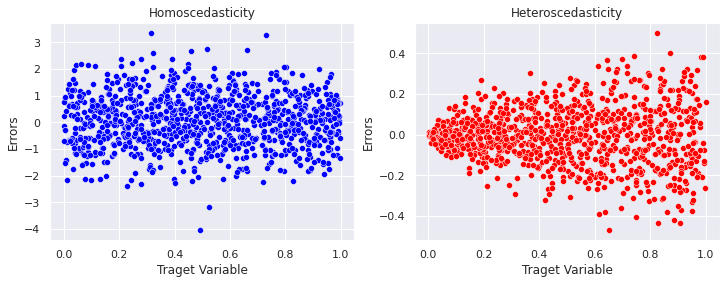

In [ ]:
sns.scatterplot(x = pipeline.predict(X_train[features2]), y=errors, alpha=0.1)

Este problema podría resolverse aplicando nuevamente transformaciones no lineales sobre las variables de entrada. Por otro lado, también puede indicar que hacen falta variables de entrada que ayuden a representar apropiadamente la variable objetivo.

## 8. Persistencia del modelo

Una vez que el modelo está listo, ¿cómo ponerlo en producción para que realice estimaciones para datos futuos?

Se debe empezar por persistir el modelo a un archivo binario para que posteriormente pueda ser reutilizado desde cualquier script o servicio.

In [ ]:
filename = "model.joblib"

In [ ]:
dump(pipeline, filename)

In [ ]:
pipeline_loaded = load(filename)